In [2]:
import joblib
import numpy as np
import pandas as pd
import pickle
import csv
import matplotlib.pyplot as plt
from datetime import timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
modelo = joblib.load("C:\\Users\\franc\\OneDrive\\Documentos\\VScode\\Github\\Franico-proyecto\\RF_clipping.joblib")

In [3]:
validate_dt = pd.read_excel('data/validation.xlsx')


validate_dt.time = validate_dt.time - timedelta(hours=4) 
validate_dt['fecha'] = validate_dt['time'].dt.date

validate_dt['time'] = pd.DatetimeIndex(validate_dt['time'])

In [12]:
def extract_data(dataframe):

    n_plantas = dataframe['id_planta'].unique()
    fecha_plantas = dataframe["fecha"].unique()
    fecha_plantas = fecha_plantas[1:-1]
    retorno = []

    for n in n_plantas:
        datos_planta = dataframe.query(f"id_planta == {n}")
        data = []


        for f in fecha_plantas:
            dt = datos_planta[datos_planta["fecha"] == f]
            pt = list(dt["Potencia Teórica"].values)          #Potencia Teórica
            pr = list(dt["Potencia Fotovoltaica"].values)     #Potencia Real
            pc = list(dt["clipping"].values)                  #Clipping
            retorno.append([pt, pr, pc])                      #Lista con los 3 vectores anteriores
    
    return retorno


def normalize_data(lista):
    '''Función que normaliza una lista con listas de generación teórica, real y clipping'''

    new_list = [ [x[0], x[1], x[2]] for x in lista ]
    L = []

    for x in new_list:
        maximo = max(max(x[0]), max(x[1]))
        x1  = [0 if i < 0 else i for i in x[0]]
        x2  = [0 if i < 0 else i for i in x[1]]
        
        x1 = x1/maximo
        x2 = x2/maximo

        L.append([x1, x2, x[2]])
    
    return L
        
def error_threshold(predict_vector, test_label, error_tolerance):
    #Función para obtener vectores predichos con cierta cantidad de errores

    error = []
    error_vector = []

    for i,j in zip(predict_vector, test_label):
        if (i != j).any():
            error.append([i,j])

        if list(i == j).count(False) == error_tolerance:
            error_vector.append([i, j])
    
    return error, error_vector

In [13]:
data = extract_data(validate_dt)
normalized_vectors = normalize_data(data)

In [15]:
# Flatten list
flatten = []
for x in normalized_vectors:
    flatten.append(list(x[0][12:-4]) + list(x[1][12:-4]))

# Clipping list
C = []
for i in data:
    C.append(i[2][12:-4])

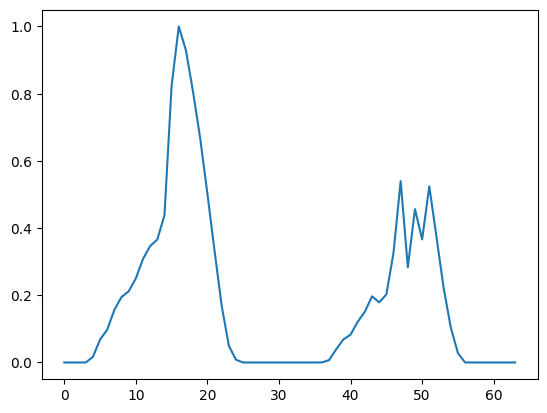

In [18]:
plt.plot(flatten[2])

In [99]:
clipping = [x[2] for x in a]

In [105]:
# Guardar las variables en un archivo
with open("validation.pkl", "wb") as archivo:
    pickle.dump((vectores_normalizados, clipping) , archivo)

In [162]:
with open("C:\\Users\\franc\\OneDrive\\Documentos\\VScode\\Github\\Franico-proyecto\\models\\modelo.pkl", 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

In [163]:
dtest = xgb.DMatrix(data = flatten2)

In [164]:
y_pred_prob = modelo_cargado.predict(dtest)

In [167]:
import numpy as np
# Umbral de decisión
threshold = 0.1

# Convertir probabilidades a etiquetas binarias
y_pred = np.where(y_pred_prob >= threshold, 1, 0)
accuracy = accuracy_score(C, y_pred)
print(accuracy)

0.2111111111111111


Text(0.5, 1.0, 'Precisión vs Umbral de error')

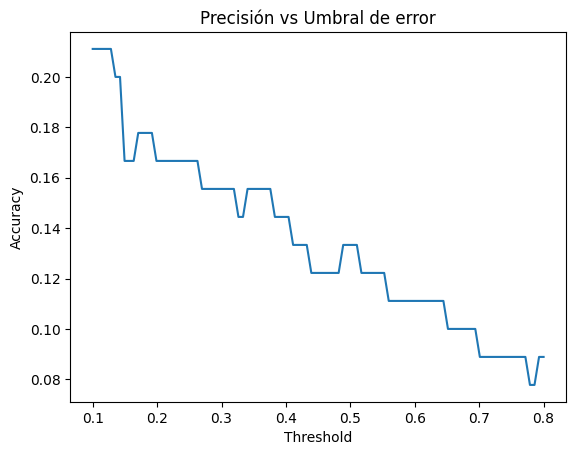

In [166]:
ummbral = np.linspace(0.1, 0.8, 100)
AC = []
for i in ummbral:
    y_pred = np.where(y_pred_prob >= i, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    AC.append(accuracy)

plt.plot(ummbral, AC)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Precisión vs Umbral de error")

In [168]:
print("")

y_test = C
x_test = flatten

prediccion = y_pred
lista1 = error_threshold(prediccion, y_test, 1)
lista2 = error_threshold(prediccion, y_test, 2)
lista3 = error_threshold(prediccion, y_test, 3)
lista4 = error_threshold(prediccion, y_test, 4)
pre = accuracy_score(prediccion, y_test)

print("total de predicciones:", len(x_test))
print("Total de vector con 1 error:", len(lista1[1]))
print("Total de vector con 2 error:", len(lista2[1]))
print("Total de vector con 3 error:", len(lista3[1]))
print("Total de vector con 4 error:", len(lista4[1]))

print("")

print("Precision con 1 error:", (len(lista1[1]) + pre*len(x_test))/len(x_test))
print("Precision con 2 errores:", (len(lista1[1]) + len(lista2[1]) + pre*len(x_test))/len(x_test))
print("Precision con 3 errores:", (len(lista1[1]) + len(lista2[1]) + len(lista3[1]) + pre*len(x_test))/len(x_test))
print("Precision con 4 errores:", (len(lista1[1]) + len(lista2[1]) + len(lista3[1]) + len(lista4[1]) + pre*len(x_test))/len(x_test))


total de predicciones: 90
Total de vector con 1 error: 14
Total de vector con 2 error: 17
Total de vector con 3 error: 13
Total de vector con 4 error: 7

Precision con 1 error: 0.36666666666666664
Precision con 2 errores: 0.5555555555555556
Precision con 3 errores: 0.7
Precision con 4 errores: 0.7777777777777778
